<a href="https://colab.research.google.com/github/linhkid/GDG-DevFest-Codelab-24/blob/main/solutions/02-a-FGSM-Adversarial-Attack_fill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Gradient Sign Method (FGSM) Adversarial Attack Workshop

## Introduction to Adversarial Attacks
In this workshop, we'll explore how to create adversarial examples using the Fast Gradient Sign Method (FGSM). These examples are carefully crafted perturbations that can cause a deep learning model to misclassify images, despite the changes being nearly imperceptible to human eyes.

## Setup and Dependencies

### Install and Import Dependencies
Run this cell to install and import all required libraries

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0


### Load Pre-trained Model

In [2]:
# Load Pre-trained ResNet50 Model
# This cell loads a pre-trained ResNet50 model that we'll try to fool

model = ResNet50(weights='imagenet')
print("Model loaded successfully!")

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Model loaded successfully!


## Helper functions

In [3]:
# Image Preprocessing Function
# This function prepares images for our model

def preprocess_image(image_path):
    """
    Loads and preprocesses an image for ResNet50.

    Args:
        image_path (str): Path to the image file

    Returns:
        numpy.ndarray: Preprocessed image array
    """
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image

## FGSM Attack Implementation

In [4]:
# This cell contains the core FGSM attack implementation

def fgsm_attack(image, epsilon, data_grad):
    """
    Implements the Fast Gradient Sign Method attack.

    Args:
        image: Input image
        epsilon: Attack strength parameter
        data_grad: Gradient of the loss with respect to the input image

    Returns:
        Adversarial image
    """
    sign_data_grad = tf.sign(data_grad)
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = tf.clip_by_value(perturbed_image, -1, 1)
    return perturbed_image

def generate_adversarial_example(image, epsilon):
    """
    Generates an adversarial example using FGSM.

    Args:
        image: Input image
        epsilon: Attack strength parameter

    Returns:
        Adversarial version of the input image
    """
    image_tensor = tf.convert_to_tensor(image)
    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        prediction = model(image_tensor)
        loss = tf.keras.losses.categorical_crossentropy(prediction, prediction)

    gradient = tape.gradient(loss, image_tensor)
    perturbed_image = fgsm_attack(image_tensor, epsilon, gradient)
    return perturbed_image

## Generate and Test Adversarial Example

In [7]:
# Run this cell to create and test an adversarial example
# You can modify the epsilon value to control attack strength

image_path = "pizza_2.jpg"  # @param {type:"string"}
epsilon = 0.089  # @param {type:"slider", min:0.001, max:0.1, step:0.001}

# Load and preprocess the image
original_image = preprocess_image(image_path)

# Generate adversarial example
adversarial_image = generate_adversarial_example(original_image, epsilon)

# Make predictions
original_pred = model.predict(original_image)
adversarial_pred = model.predict(adversarial_image)

# Decode predictions
original_label = decode_predictions(original_pred)[0][0]
adversarial_label = decode_predictions(adversarial_pred)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


## Visualize Results

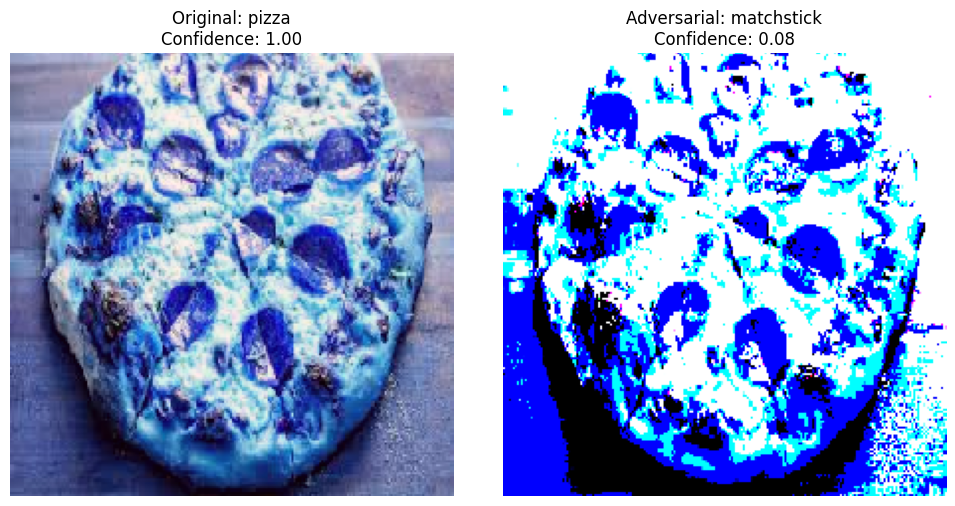

Original prediction: pizza (1.00)
Adversarial prediction: matchstick (0.08)


In [8]:
# Visualize Original vs Adversarial Images
# This cell will display the original and adversarial images side by side

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(tf.keras.preprocessing.image.array_to_img(original_image[0]))
plt.title(f"Original: {original_label[1]}\nConfidence: {original_label[2]:.2f}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(tf.keras.preprocessing.image.array_to_img(adversarial_image[0].numpy()))
plt.title(f"Adversarial: {adversarial_label[1]}\nConfidence: {adversarial_label[2]:.2f}")
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Original prediction: {original_label[1]} ({original_label[2]:.2f})")
print(f"Adversarial prediction: {adversarial_label[1]} ({adversarial_label[2]:.2f})")

## Extra Exercise Section
Try experimenting with:
1. Different epsilon values - how does this affect the attack's success and visibility?
2. Different input images - do some types of images work better than others?
3. Different target classes - can you modify the attack to target a specific class?

## Additional Notes:
- The epsilon value controls the strength of the attack. Larger values create stronger attacks but more visible perturbations.
- Some images may be more resistant to adversarial attacks than others.
- The success of the attack can vary depending on the confidence of the original prediction.